<a href="https://colab.research.google.com/github/choprasarthak98/ForensicResemblance/blob/main/ForensicResemblance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

Image Block Selection

In [ ]:


import numpy as np


def tile_image(I,width,height,x_overlap=0,y_overlap=0):
    jnds = range(0,I.shape[0]-height+1,height-y_overlap) 
    inds = range(0,I.shape[1]-width+1,width-x_overlap)   
    N = len(jnds)*len(inds)
    
    if I.ndim == 3:
        X = np.zeros((N,height,width,I.shape[2]),dtype=I.dtype) 
    elif I.ndim == 2:
        X = np.zeros((N,height,width),dtype=I.dtype) 
    else:
        raise ValueError('Expecting a single or multi-channel image array')   
        
    xy = [];
    count = 0;
    for jj in jnds:
        for ii in inds:
            X[count] = I[jj:jj+height,ii:ii+width]
            xy.append((ii,jj))
            count += 1
    return X, xy


def span_image(I,width,height,n_x=10,n_y=10,snap_to=16):
    inds = np.linspace(0,I.shape[1]-width,n_x)
    inds = np.round(inds/snap_to)*snap_to 
    i_snap_max = np.floor((I.shape[1]-width)/snap_to)*snap_to
    inds = np.clip(inds,0,i_snap_max) 
    inds = inds.astype(int) 
    
    jnds = np.linspace(0,I.shape[0]-height,n_y)
    jnds = np.round(jnds/snap_to)*snap_to 
    j_snap_max = np.floor((I.shape[0]-height)/snap_to)*snap_to
    jnds = np.clip(jnds,0,j_snap_max) 
    jnds = jnds.astype(int) 
    
    N = n_x*n_y
    
    if I.ndim == 3:
        X = np.zeros((N,height,width,I.shape[2]),dtype=I.dtype) 
    elif I.ndim == 2:
        X = np.zeros((N,height,width),dtype=I.dtype) 
    else:
        raise ValueError('Expecting a single or multi-channel image array')   
        
    xy = [];
    count = 0;
    for jj in jnds:
        for ii in inds:
            X[count] = I[jj:jj+height,ii:ii+width]
            xy.append((ii,jj))
            count += 1
    return X, xy


def span_image_by_overlap(I,width,height,x_overlap=0,y_overlap=0,snap_to=16):
    
    n_x = (I.shape[1]-width)/(width-x_overlap)
    n_x = int(np.round(n_x))
    
    n_y = (I.shape[0]-height)/(height-y_overlap)
    n_y = int(np.round(n_y))
    
    X, xy = span_image(I,width,height,n_x+1,n_y+1,snap_to=snap_to)
    
    return X, xy


Model

In [ ]:



import tensorflow as tf

def conv2d(x, w, stride=[1, 1, 1, 1], pad='SAME'):
    return tf.nn.conv2d(x, w, strides=stride, padding=pad)

def max_pooling(x, name, k_size=[1, 3, 3, 1], stride=[1, 2, 2, 1]):
    return tf.nn.max_pool(x, ksize=k_size, strides=stride, padding='VALID',name=name)

def weight_variables(name, shape):
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer())

def bias_variables(name, shape,ini_val=0):
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32, initializer=tf.constant_initializer(ini_val))

def batch_norm(input, phase):
    return tf.layers.batch_normalization(input, axis=-1, center=True,scale=True, training=phase)

#MISLNet 256x256 version
def MISLNet(x,phase,nprefilt=3,reuse=False):
    with tf.variable_scope('MISLNet',reuse=reuse) as scope:
        w_constr = weight_variables(name='weights_cstr', shape=[5, 5, 3, nprefilt])
        constr_output = conv2d(x, w_constr, pad='VALID')

        w_1 = weight_variables(name='weights_conv1', shape=[7, 7, nprefilt, 96])
        b_1 = bias_variables(name='bias_conv1', shape=[96],ini_val=0.)
        conv1 = conv2d(constr_output, w_1, stride=[1, 2, 2, 1])
        conv1 = tf.nn.bias_add(conv1, b_1)
        bn1 = batch_norm(conv1,phase)
        bn1 = tf.nn.tanh(bn1,'tanh_conv1')
        conv1_output = max_pooling(bn1, name='maxpool_conv1')

        w_2 = weight_variables(name='weights_conv2', shape=[5, 5, 96, 64])
        b_2 = bias_variables(name='bias_conv2', shape=[64],ini_val=0.)
        conv2 = conv2d(conv1_output, w_2)
        conv2 = tf.nn.bias_add(conv2, b_2)
        bn2 = batch_norm(conv2,phase)
        bn2 = tf.nn.tanh(bn2,'tanh_conv2')
        conv2_output = max_pooling(bn2, name='maxpool_conv2')

        w_3 = weight_variables(name='weights_conv3', shape=[5, 5, 64, 64])
        b_3 = bias_variables(name='bias_conv3', shape=[64],ini_val=0.)
        conv3 = conv2d(conv2_output, w_3)
        conv3 = tf.nn.bias_add(conv3, b_3)
        bn3 = batch_norm(conv3,phase)
        bn3 = tf.nn.tanh(bn3,'tanh_conv3')
        conv3_output = max_pooling(bn3, name='maxpool_conv3')

        w_4 = weight_variables(name='weights_conv4', shape=[1, 1, 64, 128])
        b_4 = bias_variables(name='bias_conv4', shape=[128],ini_val=0.)
        conv4 = conv2d(conv3_output, w_4)
        conv4 = tf.nn.bias_add(conv4, b_4)
        bn4 = batch_norm(conv4,phase)
        bn4 = tf.nn.tanh(bn4,'tanh_conv4')
        conv4_output = max_pooling(bn4, name='maxpool_conv4')

        reshaped_output = tf.reshape(conv4_output, [-1, 6 * 6 * 128]) 

        w_fc1 = weight_variables(name="weights_d1", shape=[6 * 6 * 128, 200])
        b_fc1 = tf.get_variable(name='bias_d1', shape=[200], dtype=tf.float32, initializer=tf.constant_initializer(0))
        fc1 = tf.nn.tanh(tf.add(tf.matmul(reshaped_output, w_fc1), b_fc1),name='dense1_out')

        w_fc2 = weight_variables(name='weights_d2', shape=[200, 200])
        b_fc2 = tf.get_variable(name='bias_d2', shape=[200], dtype=tf.float32, initializer=tf.constant_initializer(0))
        fc2 = tf.nn.tanh(tf.add(tf.matmul(fc1, w_fc2), b_fc2),name='dense2_out')

    return fc2




#Neural Network 256x256 
def Resemblance_256(x1,x2,phase,nprefilt=6,nb12=2048,nb3=64):

	MISL_output1 = MISLNet(x1, phase, nprefilt=nprefilt,reuse=False) 
	MISL_output2 = MISLNet(x2, phase, nprefilt=nprefilt,reuse=True) 

	with tf.variable_scope('CompareNet') as scope:

		w_fcb1 = weight_variables(name="weights_fcb1", shape=[200, nb12])
		b_fcb1 = tf.get_variable(name='bias_fcb1', shape=[nb12], dtype=tf.float32, initializer=tf.constant_initializer(0))
		fcb1 = tf.nn.relu(tf.add(tf.matmul(MISL_output1, w_fcb1), b_fcb1),name='fcb1_out')
		fcb1_drop = tf.nn.dropout(fcb1,0.5)

		fcb2 = tf.nn.relu(tf.add(tf.matmul(MISL_output2, w_fcb1), b_fcb1),name='fcb2_out')
		fcb2_drop = tf.nn.dropout(fcb2,0.5)
		
		fcb1b2_mult = tf.multiply(fcb1,fcb2,name='fcb1b2_mult')
		fcb1b2_concat = tf.concat([fcb1,fcb1b2_mult,fcb2],1)

		w_fcb3 = weight_variables(name="weights_fcb3", shape=[nb12*3, nb3])
		b_fcb3 = tf.get_variable(name='bias_fcb3', shape=[nb3], dtype=tf.float32, initializer=tf.constant_initializer(0))
		fcb3 = tf.nn.relu(tf.add(tf.matmul(fcb1b2_concat, w_fcb3), b_fcb3),name='fcb3_out')

		w_out = weight_variables(name="weights_out", shape=[nb3, 2])
		b_out = tf.get_variable(name='bias_out', shape=[2], dtype=tf.float32, initializer=tf.constant_initializer(0))
		output = tf.matmul(fcb3, w_out) + b_out

	return output





Resemblance calculation function


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


import numpy as np
from tqdm import tqdm
import tensorflow as tf

def softmax(a): 
    e = np.exp(a)
    div = np.tile(e.sum(1,keepdims=1),(1,a.shape[1]))
    sm = e/div
    return sm
    
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
    


def calculate_digital_tracing_insession(X1,X2,patch_size, sess, compare_output, tf_x1, tf_x2, MISL_phase,  batch_size = 48, quiet = False):

	if not len(X1)==len(X2):
		raise ValueError('Inputs must be the same length')
        
	list_sim = [] 

	for ix in tqdm(batch(range(len(X1)), batch_size),total = int(np.ceil(len(X1)/batch_size)),
			desc='Calculating Digital Tracing',disable=quiet): 

		result = sess.run(compare_output, feed_dict={tf_x1:X1[ix],tf_x2:X2[ix], MISL_phase:False})

		sim_batch = softmax(result)[:,1] 
		list_sim.append(sim_batch)
	
	resemblance = np.hstack(list_sim)
	return resemblance


def calculate_digital_tracing(X1, X2, f_pretrained_weights, patch_size, batch_size=48,quiet=False):
    
	
	if patch_size == 256:
		from model import Resemblance_256 as ResemblanceNetwork
	elif patch_size == 128:
		from model import Resemblance_128 as ResemblanceNetwork
	else:
	    raise TypeError('Unsupported patch size {}'.format(patch_size))

	
	tf.reset_default_graph()    
	
	tf_x1 = tf.placeholder(tf.float32, shape=[None,patch_size,patch_size,3], name='input_data1')
	tf_x2 = tf.placeholder(tf.float32, shape=[None,patch_size,patch_size,3], name='input_data2')
	MISL_phase =tf.placeholder(tf.bool, name='phase')
	
	compare_output = ResemblanceNetwork(tf_x1,tf_x2,MISL_phase)
	
	mislnet_restore = tf.train.Saver()

	with tf.Session() as sess:
	    mislnet_restore.restore(sess,f_pretrained_weights) 
	    resemblance = calculate_digital_tracing_insession(X1, X2, patch_size, sess, compare_output,
								 tf_x1, tf_x2, MISL_phase, batch_size = batch_size, quiet = quiet)


	return resemblance


In [ ]:
import sys
sys.path.append('..')
import digital_tracing as digtra 
from blockimage import tile_image 

import matplotlib.pyplot as plt
import numpy as np

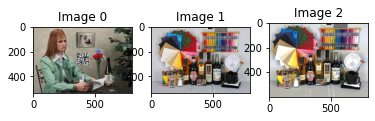

In [ ]:
I0 = plt.imread('/content/cannon1.jpg')
I1 = plt.imread('/content/cannon2.jpg')
I2 = plt.imread('/content/iphone 8.jpg')


fig,ax = plt.subplots(1,3)
ax[0].imshow(I0); ax[1].imshow(I1); ax[2].imshow(I2)
ax[0].set_title('Image 0'); ax[1].set_title('Image 1'); ax[2].set_title('Image 2')
plt.show()

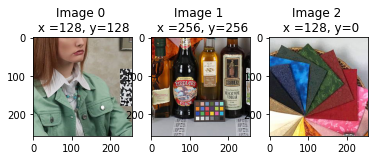

In [ ]:

patch_size = 256
overlap = 128


T0,xy0 = tile_image(I0,width=patch_size,height=patch_size, 
                x_overlap=overlap,y_overlap=overlap)

T1,xy1 = tile_image(I1,width=patch_size,height=patch_size,
                x_overlap=overlap,y_overlap=overlap)


T2,xy2 = tile_image(I2,width=patch_size,height=patch_size,
                x_overlap=overlap,y_overlap=overlap)


ind0 = np.random.randint(0,len(T0)) 
ind1 = np.random.randint(0,len(T1))
ind2 = np.random.randint(0,len(T2))

fig,ax = plt.subplots(1,3) 
ax[0].imshow(T0[ind0])
ax[1].imshow(T1[ind1])
ax[2].imshow(T2[ind2])

ax[0].set_title('Image 0 \n x ={}, y={}'.format(xy0[ind0][0],xy0[ind0][1]))
ax[1].set_title('Image 1 \n x ={}, y={}'.format(xy1[ind1][0],xy1[ind1][1]))
ax[2].set_title('Image 2 \n x ={}, y={}'.format(xy2[ind2][0],xy2[ind2][1]))

plt.show()

In [ ]:

N = 1000

inds0 = np.random.randint(0,len(T0),size=N) 
inds1 = np.random.randint(0,len(T1),size=N) 
inds2 = np.random.randint(0,len(T2),size=N)

X0 = T0[inds0] 
X1 = T1[inds1] 
X2 = T2[inds2] 

In [ ]:

f_weights = '/content/cam256x256/-30' 
sim_0_1 = forsim.calculate_digital_tracing(X0,X1,f_weights,patch_size) 
sim_0_2 = forsim.calculate_digital_tracing(X0,X2,f_weights,patch_size) 
sim_1_2 = forsim.calculate_digital_tracing(X1,X2,f_weights,patch_size) 

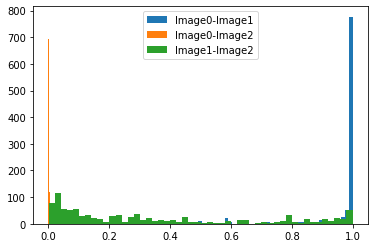

In [ ]:

fig,ax = plt.subplots(1)
ax.hist(sim_0_1,50,label='Image0-Image1')
ax.hist(sim_0_2,50,label='Image0-Image2')
ax.hist(sim_1_2,50,label='Image1-Image2')
ax.legend()
plt.show()

